# Centralized Experiment

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

import torch

from datasets import Dataset
from transformers import AutoTokenizer, Trainer, AutoModelForSequenceClassification, TrainingArguments
print(torch.__version__)
print(torch.cuda.is_available())

2.7.0+cu118
True


In [20]:
MODEL_PATH = "mBERT" # I have donloaded distilled mBERT (hugggingface not available in China)
DATA_DIR = "data"

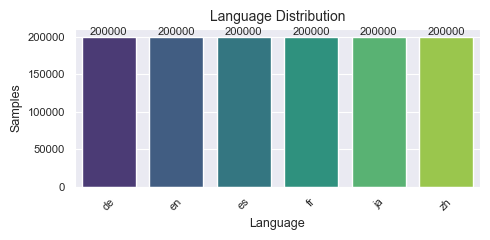

In [42]:
df = pd.read_csv(DATA_DIR + "/train.csv")
language_counts = df['language'].value_counts().reset_index()
language_counts.columns = ['language', 'count']

plt.figure(figsize=(5, 2.5))
sns.barplot(data=language_counts, x='language', y='count', hue='language', palette='viridis', legend=False)

for i, count in enumerate(language_counts['count']):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)

plt.title("Language Distribution", fontsize=10)
plt.xlabel("Language", fontsize=9)
plt.ylabel("Samples", fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [4]:
# ==== Load CSVs ====
def load_and_label(filepath, portion=0.1):
    df = pd.read_csv(filepath).sample(frac=portion, random_state=42)
    # Map stars to 0/1/2
    def map_sentiment(stars):
        if stars <= 2:
            return 0  # negative
        elif stars == 3:
            return 1  # neutral
        else:
            return 2  # positive
    df["label"] = df["stars"].apply(map_sentiment)
    return Dataset.from_pandas(df[["review_body", "label"]])

train_ds = load_and_label(os.path.join(DATA_DIR, "train.csv"))
val_ds = load_and_label(os.path.join(DATA_DIR, "validation.csv"))
test_ds = load_and_label(os.path.join(DATA_DIR, "test.csv"))

In [31]:
# ==== Tokenizer ====
print("Loading tokenizer from local path...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def tokenize(example):
    return tokenizer(example["review_body"], truncation=True, padding=True)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

columns_to_keep = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns_to_keep)
val_ds.set_format(type="torch", columns=columns_to_keep)
test_ds.set_format(type="torch", columns=columns_to_keep)

Loading tokenizer from local path...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [54]:
NUM_LABELS = 3

# ==== Load Model ====
print("Loading model from local path...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=NUM_LABELS)

# ==== Metrics ====
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

BATCH_SIZE = 32
EPOCHS = 3

# ==== Training Arguments ====
training_args = TrainingArguments(
    output_dir="results/centralized_5",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at mBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from local path...


In [55]:
# ==== Trainer ====
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

# ==== Train ====
print("Training centralized baseline...")
trainer.train()
trainer.save_model(f"./results/centralized_{EPOCHS}/best_model_centralized")

# ==== Evaluate ====
print("Evaluating on test set...")
metrics = trainer.evaluate(test_ds)
print(metrics)

Training centralized baseline...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.708300,0.662127,0.713000,0.697996
2,0.555800,0.666073,0.725000,0.712567
3,0.423600,0.749818,0.714667,0.709341


Evaluating on test set...


{'eval_loss': 0.6477234959602356, 'eval_accuracy': 0.7363333333333333, 'eval_f1': 0.7256538209854841, 'eval_runtime': 1.2547, 'eval_samples_per_second': 2391.006, 'eval_steps_per_second': 74.918, 'epoch': 3.0}


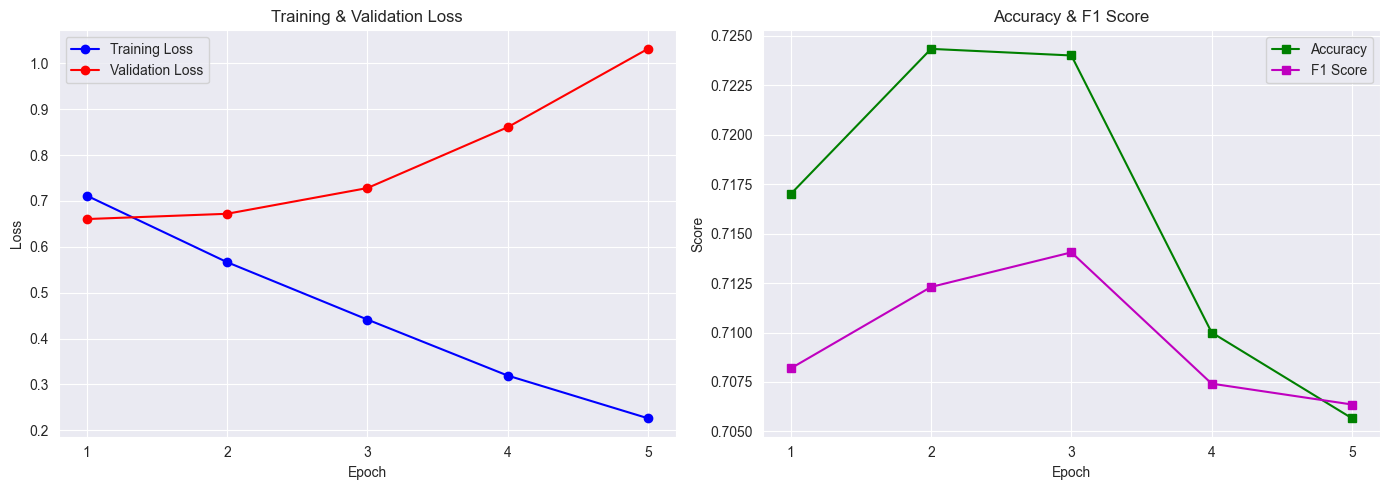

In [59]:
EPOCHS = 5
df = pd.read_csv(f'results/centralized_{EPOCHS}/training_metrics_centralized.csv')

# Create the learning curves plot
plt.figure(figsize=(14, 5))

# Plot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Training Loss'], 'b-o', label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(df['Epoch'])  # Show all epoch numbers
plt.legend()
plt.grid(True)

# Plot 2: Accuracy and F1 Score
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Accuracy'], 'g-s', label='Accuracy')
plt.plot(df['Epoch'], df['F1'], 'm-s', label='F1 Score')
plt.title('Accuracy & F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(df['Epoch'])  # Show all epoch numbers
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()